# Продвинутое глубокое обучение и обучение с подкреплением: ДЗ 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, **в качестве решения ожидается ссылка на Jupyter-ноутбук на вашем GitHub (или публичный, или с доступом для *snikolenko*); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

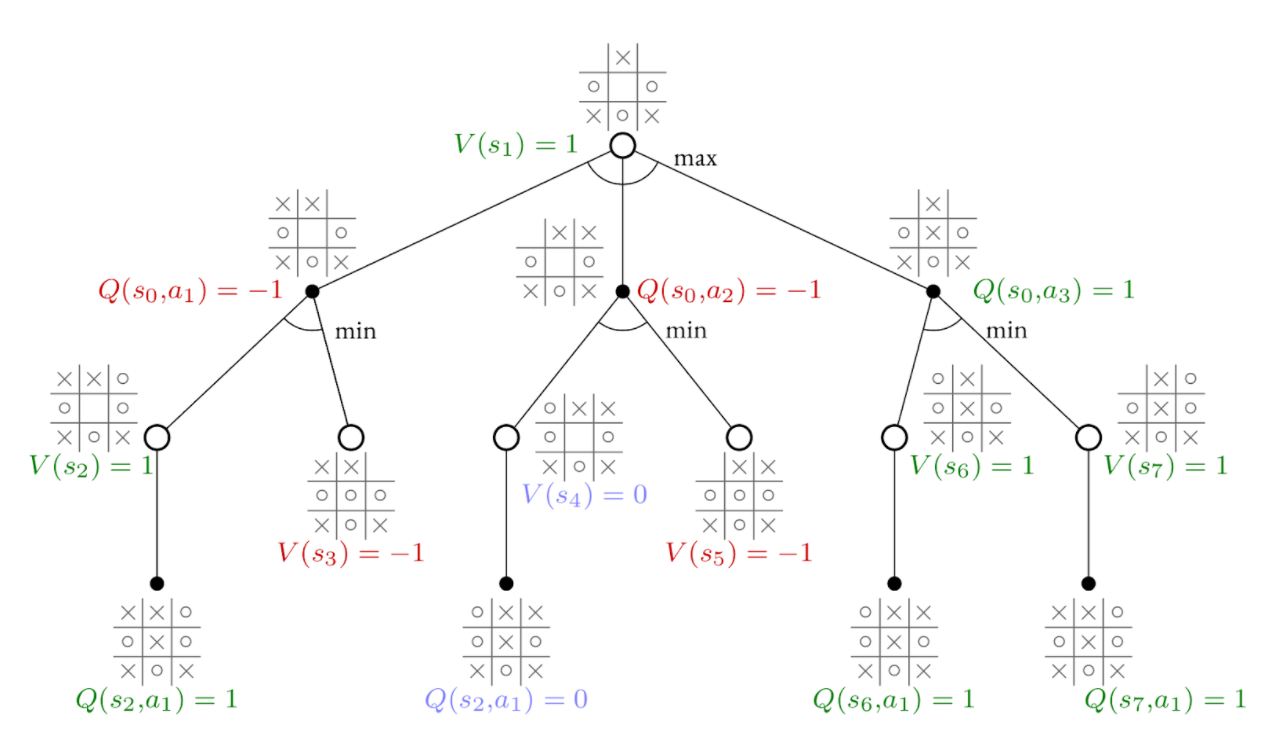

# Импорт библиотек

In [1]:
import copy
import random
from collections import deque
from collections.abc import Iterable

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

In [3]:
CROSSES = 1
NOUGHTS = -1
DRAW = 0
AGENTS = (CROSSES, NOUGHTS)

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        if clone is not None:
            self.n_rows = clone.n_rows
            self.n_cols = clone.n_cols
            self.n_win = clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = "".join(
                [f"{x + 1}"
                 for x in self.board.reshape(self.n_rows * self.n_cols)]
            )
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p
                                        for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p
                                        for k in range(self.n_win)])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print("----" * (self.n_cols) + "-")
            out = "| "
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = "x"
                if self.board[i, j] == -1:
                    token = "o"
                if self.board[i, j] == 0:
                    token = " "
                out += token + " | "
            print(out)
        print("----" * (self.n_cols) + "-")

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [5]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    """Рисуем доску с оценками из стратегии pi"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()

    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(Z, cmap=plt.get_cmap("Accent", 10), vmin=-1, vmax=1)

    if showtext:
        for i, a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text(a[1], a[0], "%.3f" % pi.Q[s][i], fontsize=fontq,
                        horizontalalignment="center",
                        verticalalignment="center",
                        color="w")

    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx,
                        horizontalalignment="center",
                        verticalalignment="center",
                        color="w")
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx,
                        horizontalalignment="center",
                        verticalalignment="center",
                        color="w")
    ax.grid(False)
    plt.show()


def get_and_print_move(env, pi, s, actions, random=False, verbose=True,
                       fontq=20, fontx=60):
    """Делаем ход, рисуем доску"""
    plot_board(env, pi, fontq=fontq, fontx=fontx)

    if verbose and (pi is not None):
        if s in pi.Q:
            for i, a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")

    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [6]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True,
                   verbose=True, fontq=20, fontx=60):
    """
    Играем тестовую партию между стратегиями или со случайными ходами,
    рисуем ход игры
    """
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses,
                                   verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts,
                                   verbose=verbose, fontq=fontq, fontx=fontx)
        _, reward, done, _ = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

Создадим доски размером 3 на 3, 4 на 4 и 5 на 5, чтобы не создавать их заново в дальнейшем:

In [7]:
ENV_3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
ENV_4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
ENV_5 = TicTacToe(n_rows=5, n_cols=5, n_win=5)

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [8]:
class RandomPolicy:
    def select_action(self, state, player: int = None, eps: float = 0.0):
        _, empty_spaces, _ = state
        return np.random.randint(len(empty_spaces))

In [9]:
class EpsGreedyPolicy:
    def __init__(self):
        self.Q = {}

    def select_action(self, state, player: int = None, eps: float = 0.0):
        board_hash, empty_spaces, _ = state

        if random.random() >= eps and board_hash in self.Q:
            return np.argmax(self.Q[board_hash])

        if board_hash not in self.Q:
            self.Q[board_hash] = np.zeros(len(empty_spaces))

        return np.random.randint(len(empty_spaces))

Будем обучать стратегии крестиков и ноликов одновременно друг на друге, а оценивать прогресс на случайной стратегии.

In [10]:
def run_episode(env, policies: dict, eps: float = 0.0):
    env.reset()
    state = env.getState()
    _, empty_spaces, cur_turn = state

    done = False
    while not done:
        action = policies[cur_turn].select_action(state, cur_turn, eps)
        action = action if isinstance(action, Iterable) else empty_spaces[action]
        state, reward, done, _ = env.step(action)
        _, empty_spaces, cur_turn = state

    return reward

In [11]:
def test_performance(env, policies: dict, num_experiments: int = 1,
                     verbose: bool = False,
                     show_progress: bool = True):
    crosses_wins = 0
    naughts_wins = 0
    draws = 0
    history = {
        "indices": [],
        "crosses": [],
        "noughts": [],
        "draws": []
    }
    for i in tqdm(range(num_experiments), disable=not show_progress):
        reward = run_episode(env, {CROSSES: policies[CROSSES], NOUGHTS: policies[NOUGHTS]}, eps=0)
        crosses_wins += int(reward == CROSSES)
        naughts_wins += int(reward == NOUGHTS)
        draws += int(reward == DRAW)
        history["indices"].append(i + 1)
        history["crosses"].append(crosses_wins / (i + 1))
        history["noughts"].append(naughts_wins / (i + 1))
        history["draws"].append(draws / (i + 1))
    
    if verbose:
        print(f"Average crosses winrate: {history['crosses'][-1]:.4f}")
        print(f"Average noughts winrate: {history['noughts'][-1]:.4f}")

    return history

In [12]:
def q_learning_episode(env, policies: dict, alpha: float, gamma: float, eps: float):
    prev_dict = {
        agent: {"action_index": None, "board_hash": None}
        for agent in policies
    }

    env.reset()
    state = env.getState()
    board_hash, empty_spaces, cur_turn = state

    done = False
    while not done:
        action_index = policies[cur_turn].select_action(state, cur_turn, eps)
        state, reward, done, _ = env.step(empty_spaces[action_index])
        if reward == cur_turn:
            policies[cur_turn].Q[board_hash][action_index] = abs(reward)

        # use new state and reward to update opposite policy weights
        next_board_hash, next_empty_spaces, next_turn = state
        prev_board_hash = prev_dict[next_turn]["board_hash"]
        prev_action_index = prev_dict[next_turn]["action_index"]
        if prev_board_hash is not None:
            gamma_term = gamma * np.max(policies[next_turn].Q[next_board_hash]) \
                         if next_board_hash in policies[next_turn].Q else 0
            policies[next_turn].Q[prev_board_hash][prev_action_index] += alpha * (
                -reward + gamma_term
                - policies[next_turn].Q[prev_board_hash][prev_action_index]
            )

        prev_dict[cur_turn] = {"action_index": action_index, "board_hash": board_hash}
        board_hash, empty_spaces, cur_turn = next_board_hash, next_empty_spaces, next_turn

    return policies

In [13]:
def q_learning(env, policies: dict, num_episodes: int = 1,
               alpha: float = 0.015, gamma: float = 1.0,
               eps_init: float = 0.9, eps_final: float = 0.01, eps_decay: float = 2_000,
               evaluate_every: int = 1_000, eval_window: int = 800,
               show_progress: bool = True):
    crosses_history = {
        "indices": [],
        "crosses": [],
        "noughts": [],
        "draws": []
    }
    noughts_history = copy.deepcopy(crosses_history)

    for i in tqdm(range(num_episodes), disable=not show_progress):
        eps = eps_init + (eps_final - eps_init) * i / eps_decay
        policies = q_learning_episode(env, policies, alpha, gamma, eps)

        if (i + 1) % evaluate_every == 0:
            history = test_performance(
                env, policies={CROSSES: policies[CROSSES], NOUGHTS: RandomPolicy()},
                num_experiments=eval_window,
                show_progress=False
            )
            crosses_history["indices"].append(i + 1)
            crosses_history["crosses"].append(history["crosses"][-1])
            crosses_history["noughts"].append(history["noughts"][-1])
            crosses_history["draws"].append(history["draws"][-1])

            history = test_performance(
                env, policies={CROSSES: RandomPolicy(), NOUGHTS: policies[NOUGHTS]},
                num_experiments=eval_window,
                show_progress=False
            )
            noughts_history["indices"].append(i + 1)
            noughts_history["crosses"].append(history["crosses"][-1])
            noughts_history["noughts"].append(history["noughts"][-1])
            noughts_history["draws"].append(history["draws"][-1])

    return crosses_history, noughts_history

In [14]:
def plot_history(history, fontsize: int = 16, figsize: tuple = (12, 6)):
    plt.figure(figsize=figsize)
    plt.title("Average winrate during training", fontsize=fontsize)
    plt.xlabel("Step", fontsize=fontsize)
    plt.ylabel("Average winrate", fontsize=fontsize)
    plt.plot(history["indices"], history["crosses"], label="Crosses")
    plt.plot(history["indices"], history["noughts"], label="Noughts")
    plt.plot(history["indices"], history["draws"], label="Draws")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [15]:
policies = {
    agent: EpsGreedyPolicy()
    for agent in AGENTS
}

crosses_history, noughts_history = q_learning(
    ENV_3, policies, num_episodes=10_000,
    gamma=0.8, eps_decay=9_000,
    evaluate_every=500, eval_window=250
)

100%|██████████| 10000/10000 [00:07<00:00, 1389.71it/s]


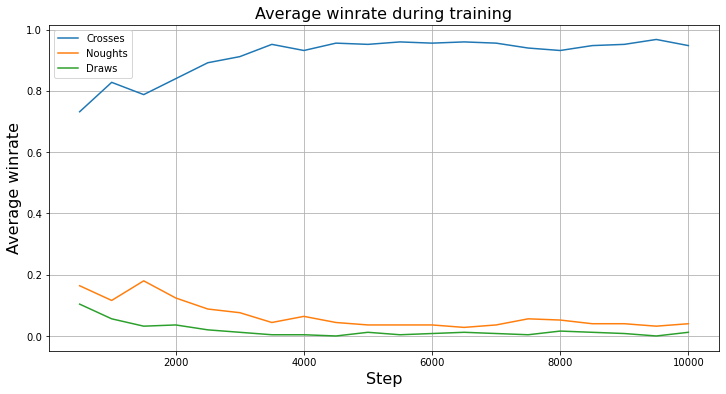

In [16]:
plot_history(crosses_history)

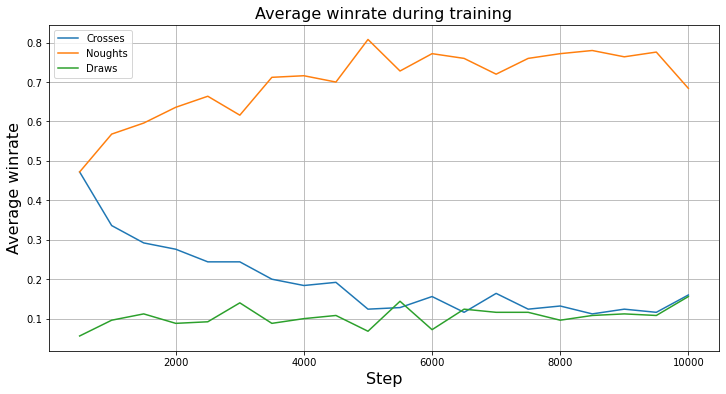

In [17]:
plot_history(noughts_history)

Сохраним полученные стратегии, чтобы переиспользовать их в дальнейшем:

In [18]:
ENV_3_Q_CROSSES = copy.deepcopy(policies[CROSSES])
ENV_3_Q_NOUGHTS = copy.deepcopy(policies[NOUGHTS])

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [19]:
policies = {
    agent: EpsGreedyPolicy()
    for agent in AGENTS
}

crosses_history, noughts_history = q_learning(
    ENV_4, policies, num_episodes=50_000,
    gamma=0.8, eps_decay=48_000,
    evaluate_every=2_500, eval_window=1_500
)

100%|██████████| 50000/50000 [01:30<00:00, 552.65it/s] 


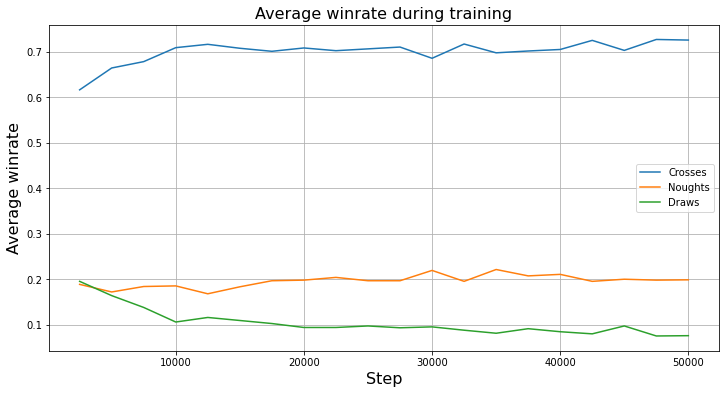

In [20]:
plot_history(crosses_history)

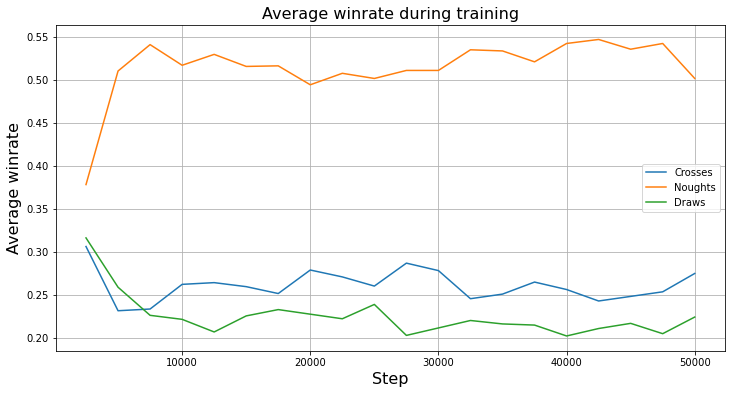

In [21]:
plot_history(noughts_history)

In [22]:
ENV_4_Q_CROSSES = copy.deepcopy(policies[CROSSES])
ENV_4_Q_NOUGHTS = copy.deepcopy(policies[NOUGHTS])

In [23]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=5)

policies = {
    agent: EpsGreedyPolicy()
    for agent in AGENTS
}

crosses_history, noughts_history = q_learning(
    env, policies, num_episodes=100_000,
    gamma=0.8, eps_decay=95_000,
    evaluate_every=5_000, eval_window=2_500
)

100%|██████████| 100000/100000 [05:46<00:00, 288.21it/s]


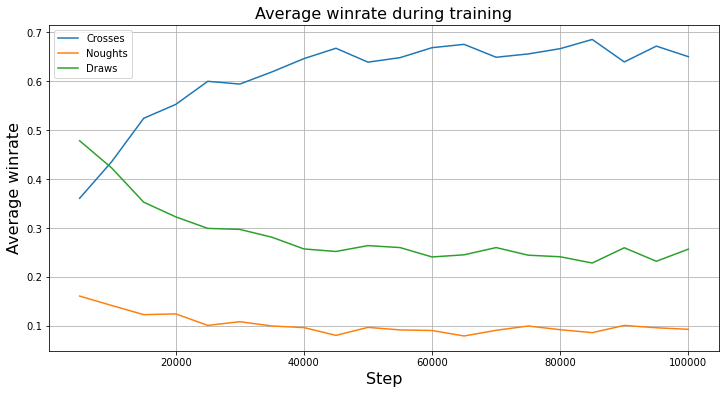

In [24]:
plot_history(crosses_history)

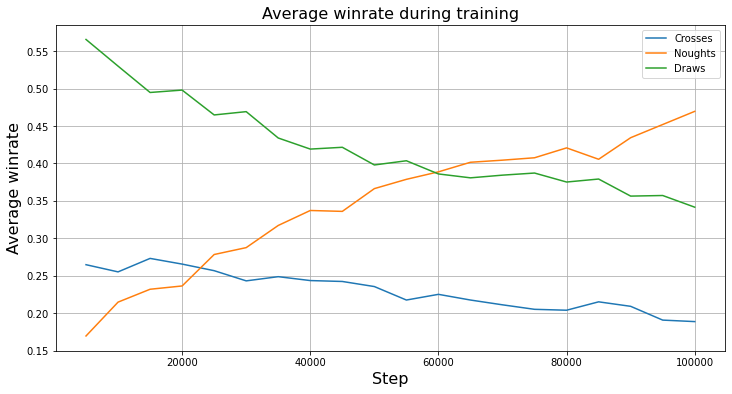

In [25]:
plot_history(noughts_history)

In [26]:
ENV_5_Q_CROSSES = copy.deepcopy(policies[CROSSES])
ENV_5_Q_NOUGHTS = copy.deepcopy(policies[NOUGHTS])

**Disclaimer:** начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий — не страшно, но покажите, что со временем что-то всё-таки улучшается.

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

Решению очень поспособствовала [реализация DQN для среды CartPole от PyTorch](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

In [27]:
class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size: int = 64):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [28]:
class ConvNet(nn.Module):
    def __init__(self, output_dim: int,
                 hidden_dim: int = 16,
                 kernel_size: tuple = (3, 3)):
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=3,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            padding=1
        )
        self.conv_2 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            padding=1
        )
        self.activation = nn.ReLU()
        self.linear = nn.Linear(
            in_features=hidden_dim * output_dim,
            out_features=output_dim
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [29]:
class DQN:
    def __init__(self, env, model: nn.Module, device: torch.device = torch.device("cpu")):
        self.env = env
        self.n_rows = self.env.n_rows
        self.n_cols = self.env.n_cols
        self.device = device

        self.models = {
            agent: model(output_dim=self.n_rows * self.n_cols).to(self.device)
            for agent in AGENTS
        }

        self.num_step = 0

    def board_to_tensor(self, board_hash):
        board = np.array([float(cell) for cell in board_hash]).reshape(
            (self.n_rows, self.n_cols)
        )
        crosses = torch.FloatTensor(board == 2)
        noughts = torch.FloatTensor(board == 0)
        empty_spaces = torch.FloatTensor(board == 1)
        return torch.stack((crosses, noughts, empty_spaces))

    def select_action(self, state, player, eps: float = 0.0):
        board_hash, _, _ = state
        board_tensor = self.board_to_tensor(board_hash).to(self.device)
        if random.random() >= eps:
            action_index = self.models[player](board_tensor.unsqueeze(0)).max(dim=1)[1].view(1, 1)
            return self.env.action_from_int(action_index)
        else:
            action_index = random.randrange(self.n_rows * self.n_cols)
            return self.env.action_from_int(action_index)

In [30]:
def optimization_step(dqn, memories, criterion, optimizers, cur_turn,
                      batch_size: int = 64, gamma: float = 0.8):
    if np.min([len(memories[cur_turn]), len(memories[-cur_turn])]) < batch_size:
        return

    # extract mini-batch from replay memory
    transitions = memories[cur_turn].sample(batch_size)
    batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

    batch_state = Variable(torch.stack(batch_state).to(dqn.device))
    batch_action = Variable(torch.cat(batch_action).to(dqn.device))
    batch_reward = Variable(torch.cat(batch_reward).to(dqn.device))
    batch_next_state = Variable(torch.stack(batch_next_state).to(dqn.device))

    # calculate Q-function
    state_action_values  = dqn.models[cur_turn](batch_state).gather(1, batch_action).reshape([batch_size])

    # state value or 0 in case the state was final
    next_state_values = dqn.models[cur_turn](batch_next_state).max(1)[0].detach()

    # compute the expected Q values
    expected_state_action_values = gamma * next_state_values + batch_reward

    optimizers[cur_turn].zero_grad()
    loss = criterion(state_action_values, expected_state_action_values)
    loss.backward()
    for param in dqn.models[cur_turn].parameters():
        param.grad.data.clamp_(-1, 1)
    optimizers[cur_turn].step()


def dqn_training_step(dqn, criterion, optimizers, memories,
                      batch_size: int = 64, eps_init: float = 0.9,
                      eps_final: float = 0.01, eps_decay: int = 10_000,
                      gamma: float = 0.8):
    dqn.env.reset()
    previous_states = {
        agent: None
        for agent in AGENTS
    }
    previous_actions = {}
    state = dqn.env.getState()
    board_hash, _, cur_turn = state

    done = False
    while not done:
        board_tensor = dqn.board_to_tensor(board_hash).to(dqn.device)
        dqn.num_step += 1
        eps = eps_init + (eps_final - eps_init) * dqn.num_step / eps_decay
        with torch.no_grad():
            action = dqn.select_action(state, cur_turn, eps)

        action_index = torch.tensor(
            dqn.env.int_from_action(action),
            device=dqn.device,
            dtype=torch.long
        ).view(1, 1)
        previous_states[cur_turn] = board_tensor
        previous_actions[cur_turn] = action_index
        state, reward, done, _ = dqn.env.step(action)
        next_board_hash, _, cur_turn = state
        board_hash = next_board_hash
        next_board_tensor = dqn.board_to_tensor(next_board_hash)

        if reward == -10:
            transition = (board_tensor, action_index, next_board_tensor, torch.tensor([reward], dtype=torch.float32))
            memories[cur_turn].push(transition)
        else:
            if previous_states[cur_turn] is not None:
                if reward == -cur_turn: 
                    transition = (previous_states[-cur_turn], previous_actions[-cur_turn],
                                    next_board_tensor, torch.tensor([1.0], dtype=torch.float32))
                    memories[-cur_turn].push(transition)
                transition = (previous_states[cur_turn], previous_actions[cur_turn],
                                next_board_tensor, torch.tensor([reward * cur_turn], dtype=torch.float32))
                memories[cur_turn].push(transition)

        optimization_step(dqn, memories, criterion, optimizers, cur_turn, batch_size, gamma)


def train_dqn(dqn, num_epochs: int, learning_rate: float = 1e-4, batch_size: int = 64,
              weight_decay: float = 5e-4, memory_size: int = 50_000,
              eps_init: float = 0.9, eps_final: float = 0.01, eps_decay: int = 10_000,
              evaluate_every: int = 1000, eval_window: int = 500,
              show_progress: bool = False):
    crosses_history = {
        "indices": [],
        "crosses": [],
        "noughts": [],
        "draws": []
    }
    noughts_history = copy.deepcopy(crosses_history)
    memories = {
        agent: ReplayMemory(memory_size * dqn.env.n_rows * dqn.env.n_cols)
        for agent in AGENTS
    }
    criterion = nn.SmoothL1Loss()
    optimizers = {
        agent: optim.Adam(
            dqn.models[agent].parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        ) for agent in AGENTS
    }

    for i in tqdm(
        range(num_epochs),
        desc=f"Training on {dqn.device}",
        disable=not show_progress
    ):
        dqn_training_step(dqn, criterion, optimizers, memories,
                          batch_size, eps_init, eps_final, eps_decay)
        if (i + 1) % evaluate_every == 0:
            history = test_performance(
                dqn.env,
                policies={CROSSES: dqn, NOUGHTS: RandomPolicy()},
                num_experiments=eval_window,
                show_progress=False
            )
            crosses_history["indices"].append(i + 1)
            crosses_history["crosses"].append(history["crosses"][-1])
            crosses_history["noughts"].append(history["noughts"][-1])
            crosses_history["draws"].append(history["draws"][-1])

            history = test_performance(
                dqn.env,
                policies={CROSSES: RandomPolicy(), NOUGHTS: dqn},
                num_experiments=eval_window,
                show_progress=False
            )
            noughts_history["indices"].append(i + 1)
            noughts_history["crosses"].append(history["crosses"][-1])
            noughts_history["noughts"].append(history["noughts"][-1])
            noughts_history["draws"].append(history["draws"][-1])
    
    return crosses_history, noughts_history

In [31]:
dqn = DQN(env=ENV_3, model=ConvNet, device=device)

crosses_history, noughts_history = train_dqn(
    dqn, num_epochs=10_000,
    eps_decay=9_000,
    evaluate_every=500,
    eval_window=250,
    show_progress=True
)

Training on cuda: 100%|██████████| 10000/10000 [05:17<00:00, 31.53it/s]


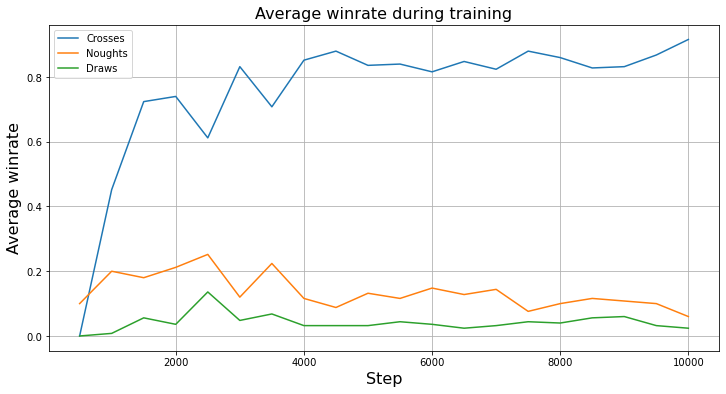

In [32]:
plot_history(crosses_history)

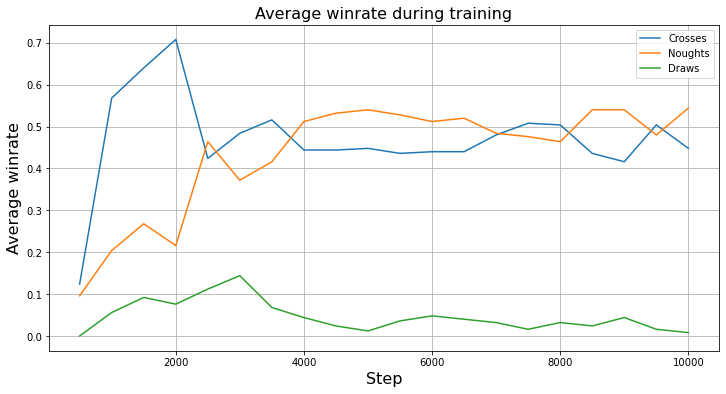

In [33]:
plot_history(noughts_history)

In [34]:
ENV_3_DQN = copy.deepcopy(dqn)

In [35]:
dqn = DQN(env=ENV_4, model=ConvNet, device=device)

crosses_history, noughts_history = train_dqn(
    dqn, num_epochs=15_000,
    eps_decay=13_500,
    evaluate_every=750,
    eval_window=400,
    show_progress=True
)

Training on cuda: 100%|██████████| 15000/15000 [11:32<00:00, 21.66it/s]


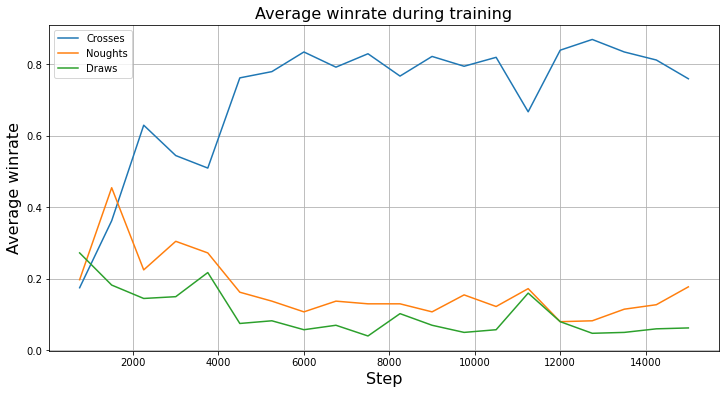

In [36]:
plot_history(crosses_history)

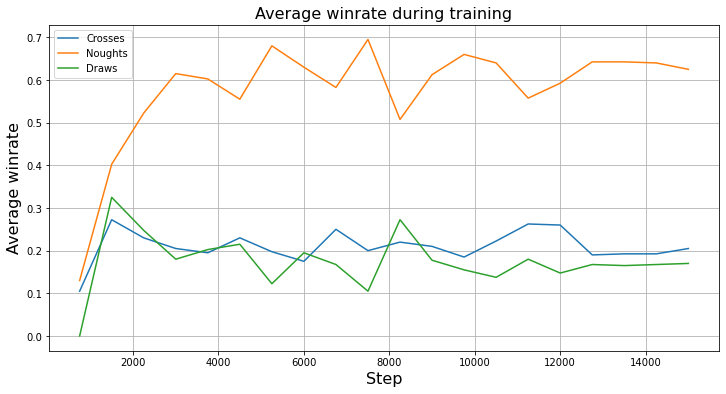

In [37]:
plot_history(noughts_history)

In [38]:
ENV_4_DQN = copy.deepcopy(dqn)

In [39]:
dqn = DQN(env=ENV_5, model=ConvNet, device=device)

crosses_history, noughts_history = train_dqn(
    dqn, num_epochs=20_000,
    eps_decay=18_000,
    evaluate_every=1_000,
    eval_window=500,
    show_progress=True
)

Training on cuda: 100%|██████████| 20000/20000 [26:31<00:00, 12.57it/s]


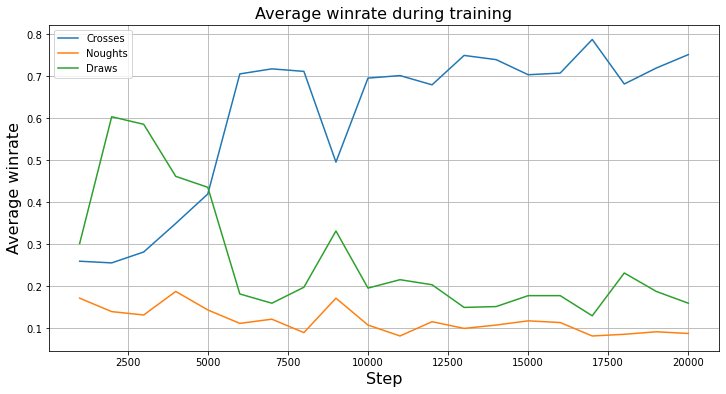

In [40]:
plot_history(crosses_history)

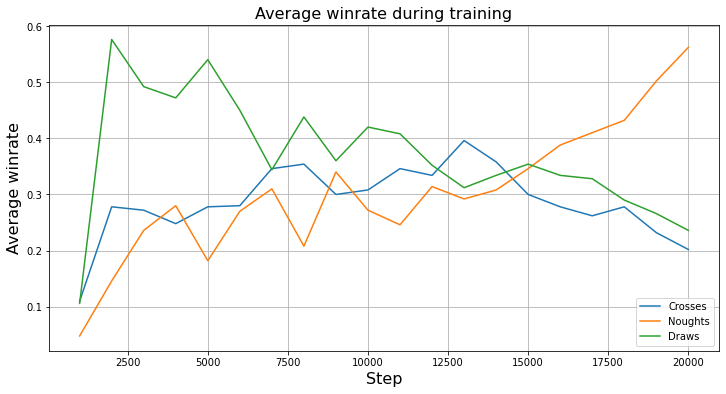

In [41]:
plot_history(noughts_history)

In [42]:
ENV_5_DQN = copy.deepcopy(dqn)

4. Реализуйте Double DQN и/или Dueling DQN.

In [43]:
class DuelingConvNet(nn.Module):
    def __init__(self, output_dim: int,
                 hidden_dim: int = 16,
                 kernel_size: tuple = (3, 3)):
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=3,
            out_channels=hidden_dim * 2,
            kernel_size=kernel_size,
            padding=1
        )
        self.conv_2 = nn.Conv2d(
            in_channels=hidden_dim * 2,
            out_channels=hidden_dim * 2,
            kernel_size=kernel_size,
            padding=1
        )
        self.activation = nn.ReLU()
        self.linear = nn.Linear(
            in_features=hidden_dim * output_dim * 2,
            out_features=hidden_dim * output_dim
        )
        self.linear_action = nn.Linear(
            in_features=hidden_dim * output_dim,
            out_features=output_dim
        )
        self.linear_value = nn.Linear(
            in_features=hidden_dim * output_dim,
            out_features=1
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        x = self.activation(x)
        value = self.linear_value(x)
        action = self.linear_action(x)
        x = value + (action - action.mean(dim=1, keepdim=True))
        return x

In [44]:
dqn = DQN(env=ENV_3, model=DuelingConvNet, device=device)

crosses_history, noughts_history = train_dqn(
    dqn, num_epochs=10_000,
    eps_decay=9_000,
    evaluate_every=500,
    eval_window=250,
    show_progress=True
)

Training on cuda: 100%|██████████| 10000/10000 [05:49<00:00, 28.62it/s]


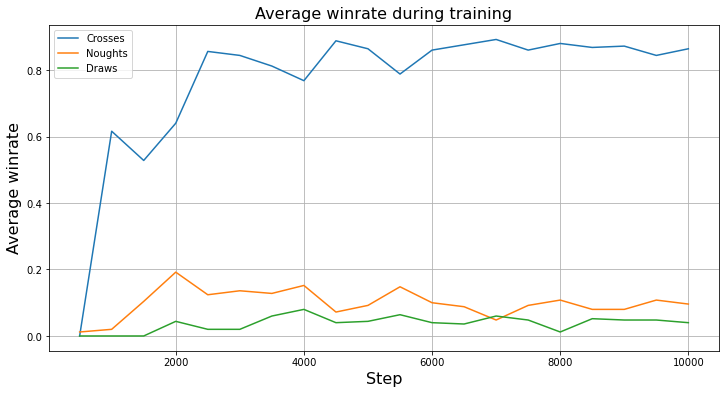

In [45]:
plot_history(crosses_history)

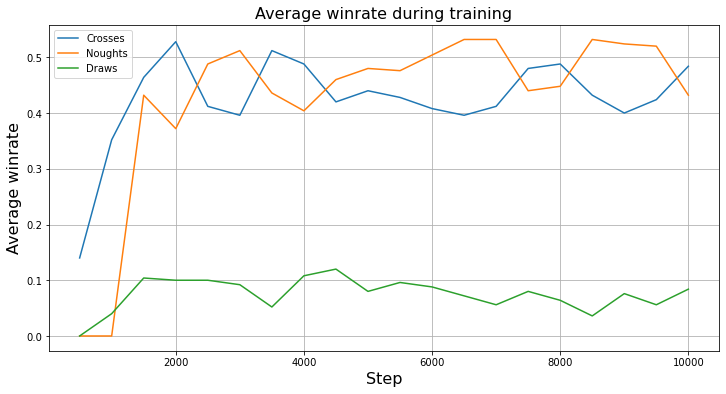

In [46]:
plot_history(noughts_history)

In [47]:
ENV_3_DUELING_DQN = copy.deepcopy(dqn)

In [48]:
dqn = DQN(env=ENV_4, model=DuelingConvNet, device=device)

crosses_history, noughts_history = train_dqn(
    dqn, num_epochs=15_000,
    eps_decay=13_500,
    evaluate_every=750,
    eval_window=400,
    show_progress=True
)

Training on cuda: 100%|██████████| 15000/15000 [15:03<00:00, 16.60it/s]


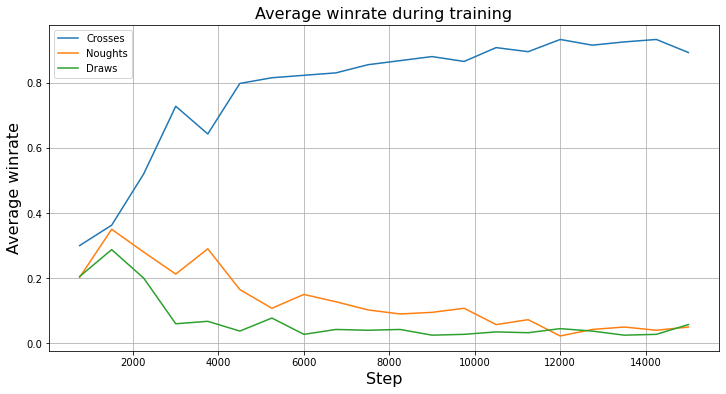

In [49]:
plot_history(crosses_history)

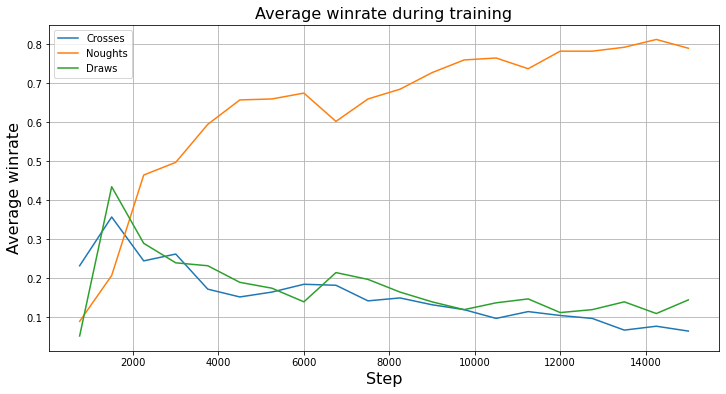

In [50]:
plot_history(noughts_history)

In [51]:
ENV_4_DUELING_DQN = copy.deepcopy(dqn)

In [52]:
dqn = DQN(env=ENV_5, model=DuelingConvNet, device=device)

crosses_history, noughts_history = train_dqn(
    dqn, num_epochs=20_000,
    eps_decay=18_000,
    evaluate_every=1_000,
    eval_window=500,
    show_progress=True
)

Training on cuda: 100%|██████████| 20000/20000 [37:01<00:00,  9.00it/s]


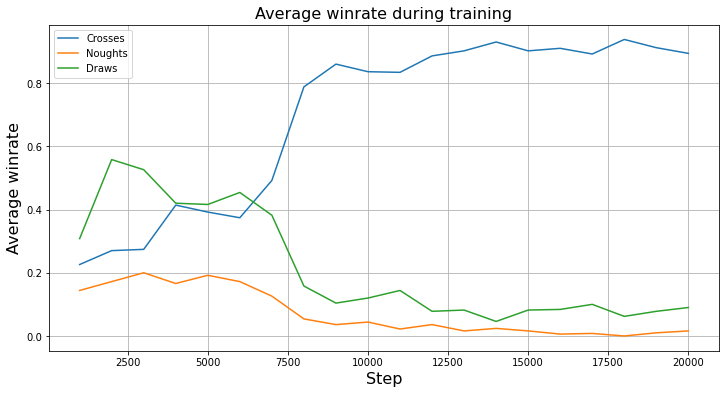

In [53]:
plot_history(crosses_history)

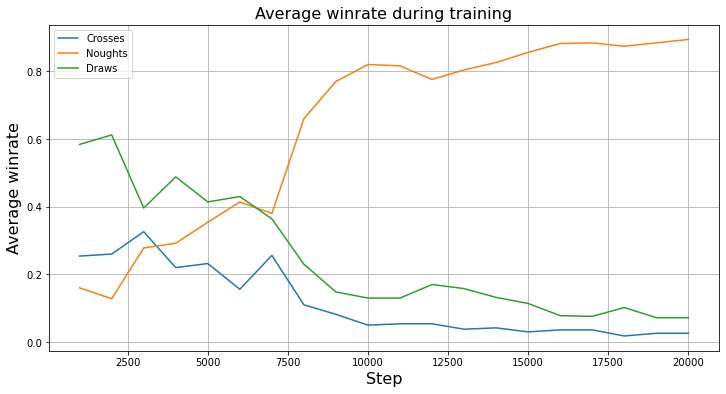

In [54]:
plot_history(noughts_history)

In [55]:
ENV_5_DUELING_DQN = copy.deepcopy(dqn)

# Часть третья: расширим и углубим поиск

Крестики-нолики — это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS — заодно фактически получится и упражнение на многоруких бандитов.

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

В реализации rollouts будем использовать стратегию агента при ходе агента и случайную стратегию в противном случае.

In [56]:
def rollout(env, action, policies, num_rollouts: int = 40):
    total_reward = 0
    for _ in range(num_rollouts):
        env_copy = copy.deepcopy(env)
        state, reward, done, _ = env_copy.step(action)
        _, empty_spaces, cur_turn = state

        while not done:
            action_index = policies[cur_turn].select_action(state, cur_turn)
            state, reward, done, _ = env_copy.step(empty_spaces[action_index])
            _, empty_spaces, cur_turn = state

        total_reward += reward

    return total_reward / num_rollouts

In [57]:
def run_episode_with_rollouts(env, policies, num_rollouts: int = 40):
    random_pi = RandomPolicy()
    env.reset()
    state = env.getState()
    _, empty_spaces, cur_turn = state
    reward = 0

    done = False
    while not done:
        if policies[cur_turn] is not None:
            best_reward = -10
            action_index = 0
            for i, action in enumerate(empty_spaces):
                avg_reward = cur_turn * rollout(
                    env, action,
                    {cur_turn: policies[cur_turn], -cur_turn: random_pi},
                    num_rollouts=num_rollouts
                )
                if avg_reward > best_reward:
                    best_reward = avg_reward
                    action_index = i
        else:
            action_index = random_pi.select_action(state)
        state, reward, done, _ = env.step(empty_spaces[action_index])
        _, empty_spaces, cur_turn = state

    return reward

In [58]:
def test_rollouts(env, policies, num_episodes: int = 1,
                  num_rollouts: int = 40, show_progress: bool = True):
    crosses_wins = 0
    noughts_wins = 0
    for _ in tqdm(range(num_episodes), disable=not show_progress):
        reward = run_episode_with_rollouts(env, policies, num_rollouts)
        crosses_wins += int(reward == CROSSES)
        noughts_wins += int(reward == NOUGHTS)

    print(f"Average winrate of crosses: {crosses_wins / num_episodes:.4f}")
    print(f"Average winrate of noughts: {noughts_wins / num_episodes:.4f}")

Для поля 3 на 3:

In [59]:
test_rollouts(
    ENV_3,
    policies={CROSSES: RandomPolicy(), NOUGHTS: None},
    num_episodes=100
)

100%|██████████| 100/100 [00:26<00:00,  3.79it/s]

Average winrate of crosses: 0.9900
Average winrate of noughts: 0.0000


In [60]:
test_rollouts(
    ENV_3,
    policies={CROSSES: None, NOUGHTS: RandomPolicy()},
    num_episodes=100
)

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]

Average winrate of crosses: 0.0500
Average winrate of noughts: 0.8700


In [62]:
test_rollouts(
    ENV_3,
    policies={CROSSES: ENV_3_Q_CROSSES, NOUGHTS: None},
    num_episodes=100
)

100%|██████████| 100/100 [00:21<00:00,  4.57it/s]

Average winrate of crosses: 1.0000
Average winrate of noughts: 0.0000


In [63]:
test_rollouts(
    ENV_3,
    policies={CROSSES: None, NOUGHTS: ENV_3_Q_NOUGHTS},
    num_episodes=100
)

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]

Average winrate of crosses: 0.0500
Average winrate of noughts: 0.9100


Для поля 4 на 4:

In [64]:
test_rollouts(
    ENV_4,
    policies={CROSSES: RandomPolicy(), NOUGHTS: None},
    num_episodes=100
)

100%|██████████| 100/100 [02:39<00:00,  1.60s/it]

Average winrate of crosses: 0.9600
Average winrate of noughts: 0.0000


In [65]:
test_rollouts(
    ENV_4,
    policies={CROSSES: None, NOUGHTS: RandomPolicy()},
    num_episodes=100
)

100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

Average winrate of crosses: 0.0000
Average winrate of noughts: 0.9400


In [67]:
test_rollouts(
    ENV_4,
    policies={CROSSES: ENV_4_Q_CROSSES, NOUGHTS: None},
    num_episodes=100
)

100%|██████████| 100/100 [02:15<00:00,  1.36s/it]

Average winrate of crosses: 0.9500
Average winrate of noughts: 0.0100


In [68]:
test_rollouts(
    ENV_4,
    policies={CROSSES: None, NOUGHTS: ENV_4_Q_NOUGHTS},
    num_episodes=100
)

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]

Average winrate of crosses: 0.0000
Average winrate of noughts: 0.9100


Для поля 5 на 5:

In [69]:
test_rollouts(
    ENV_5,
    policies={CROSSES: RandomPolicy(), NOUGHTS: None},
    num_episodes=100
)

100%|██████████| 100/100 [11:34<00:00,  6.95s/it]

Average winrate of crosses: 0.9000
Average winrate of noughts: 0.0000


In [70]:
test_rollouts(
    ENV_5,
    policies={CROSSES: None, NOUGHTS: RandomPolicy()},
    num_episodes=100
)

100%|██████████| 100/100 [10:31<00:00,  6.32s/it]

Average winrate of crosses: 0.0000
Average winrate of noughts: 0.8900


In [71]:
test_rollouts(
    ENV_5,
    policies={CROSSES: ENV_5_Q_CROSSES, NOUGHTS: None},
    num_episodes=100
)

100%|██████████| 100/100 [10:17<00:00,  6.18s/it]

Average winrate of crosses: 0.9400
Average winrate of noughts: 0.0000


In [72]:
test_rollouts(
    ENV_5,
    policies={CROSSES: None, NOUGHTS: ENV_5_Q_NOUGHTS},
    num_episodes=100
)

100%|██████████| 100/100 [10:08<00:00,  6.08s/it]

Average winrate of crosses: 0.0000
Average winrate of noughts: 0.9300


Как можно заметить, использование rollouts позволяет существенно повысить шансы на победу при игре против случайной стратегии.

6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [73]:
class MctsNode:
    def __init__(self, env, parent=None):
        self.env = copy.deepcopy(env)
        self.is_terminal = self.env.isTerminal() is not None
        self.parent = parent
        self.children = []
        self.num_visits = 0
        self.reward = 0
        self.new_actions = list(self.env.getEmptySpaces())

    def select_best_child(self, exploration_coef: float = 1.0):
        children_scores = [
            child.reward / child.num_visits
            + exploration_coef * np.sqrt((np.log(self.num_visits) / child.num_visits))
            for child in self.children
        ]
        return np.argmax(children_scores)

    def expand(self):
        action = self.new_actions.pop(0)

        next_env = copy.deepcopy(self.env)
        next_env.step(action)

        child_node = MctsNode(next_env, parent=self)
        self.children.append(child_node)

        return child_node

    def rollout(self):
        rollout_env = copy.deepcopy(self.env)

        reward = rollout_env.isTerminal()
        empty_spaces = rollout_env.getEmptySpaces()

        done = self.is_terminal
        while not done:
            action = random.choice(empty_spaces)
            (_, empty_spaces, _), reward, done, _ = rollout_env.step(action)
        return reward * self.env.curTurn

    def backprop(self, reward):
        self.num_visits += 1
        self.reward -= reward
        if self.parent:
            self.parent.backprop(-reward)

In [74]:
class MctsPolicy:
    def __init__(self, env, num_simulations: int = 100):
        self.env = env
        self.num_simulations = num_simulations

    def select_action(self, state, player: int = None, eps: float = 0.0):
        tree_root = MctsNode(self.env)

        for _ in range(self.num_simulations):
            node = tree_root
            while not node.is_terminal:
                if len(node.new_actions) > 0:
                    node = node.expand()
                else:
                    node = node.children[node.select_best_child(exploration_coef=1.4)]
            reward = node.rollout()
            node.backprop(reward)
        return tree_root.select_best_child(exploration_coef=0)

Сравнение всех стратегий между собой вынесем в отдельный блок. Для каждой доски в конце есть сводная табличка. Поехали!

# Сравнение моделей

## Доска 3 на 3

In [75]:
_ = test_performance(
    ENV_3,
    {CROSSES: RandomPolicy(), NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 1895.03it/s]

Average crosses winrate: 0.5600
Average noughts winrate: 0.3200


In [76]:
_ = test_performance(
    ENV_3,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_3_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 2013.23it/s]

Average crosses winrate: 0.1200
Average noughts winrate: 0.7200


In [77]:
_ = test_performance(
    ENV_3,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_3_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 371.31it/s]

Average crosses winrate: 0.4600
Average noughts winrate: 0.5300


In [78]:
_ = test_performance(
    ENV_3,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_3_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 287.71it/s]

Average crosses winrate: 0.4800
Average noughts winrate: 0.4300


In [79]:
_ = test_performance(
    ENV_3,
    {CROSSES: RandomPolicy(), NOUGHTS: MctsPolicy(ENV_3, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:08<00:00, 11.96it/s]

Average crosses winrate: 0.0600
Average noughts winrate: 0.8700


In [80]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_Q_CROSSES, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 2419.40it/s]

Average crosses winrate: 0.8900
Average noughts winrate: 0.0900


In [81]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_Q_CROSSES, NOUGHTS: ENV_3_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 2203.78it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [82]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_Q_CROSSES, NOUGHTS: ENV_3_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 442.45it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [83]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_Q_CROSSES, NOUGHTS: ENV_3_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 520.31it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [84]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_Q_CROSSES, NOUGHTS: MctsPolicy(ENV_3, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:08<00:00, 11.23it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [85]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DQN, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 364.31it/s]

Average crosses winrate: 0.8900
Average noughts winrate: 0.0900


In [86]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DQN, NOUGHTS: ENV_3_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 470.13it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [87]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DQN, NOUGHTS: ENV_3_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 270.20it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [88]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DQN, NOUGHTS: ENV_3_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 200.12it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [89]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DQN, NOUGHTS: MctsPolicy(ENV_3, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:08<00:00, 11.47it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 0.0000


In [90]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DUELING_DQN, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 287.01it/s]

Average crosses winrate: 0.9300
Average noughts winrate: 0.0500


In [91]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DUELING_DQN, NOUGHTS: ENV_3_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 261.46it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [92]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DUELING_DQN, NOUGHTS: ENV_3_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 277.47it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [93]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DUELING_DQN, NOUGHTS: ENV_3_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 246.73it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [94]:
_ = test_performance(
    ENV_3,
    {CROSSES: ENV_3_DUELING_DQN, NOUGHTS: MctsPolicy(ENV_3, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:09<00:00, 10.87it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [95]:
_ = test_performance(
    ENV_3,
    {CROSSES: MctsPolicy(ENV_3, num_simulations=50), NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:10<00:00,  9.91it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [96]:
_ = test_performance(
    ENV_3,
    {CROSSES: MctsPolicy(ENV_3, num_simulations=50), NOUGHTS: ENV_3_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:11<00:00,  8.46it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 0.0000


In [97]:
_ = test_performance(
    ENV_3,
    {CROSSES: MctsPolicy(ENV_3, num_simulations=50), NOUGHTS: ENV_3_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:09<00:00, 10.14it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [98]:
_ = test_performance(
    ENV_3,
    {CROSSES: MctsPolicy(ENV_3, num_simulations=50), NOUGHTS: ENV_3_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:09<00:00, 10.33it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [99]:
_ = test_performance(
    ENV_3,
    {CROSSES: MctsPolicy(ENV_3, num_simulations=50), NOUGHTS: MctsPolicy(ENV_3, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:19<00:00,  5.16it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


|                  | RandomPolicy    | Q-learning      | DQN             | DuelingDQN      | MCTS            | Время обучения, сек |
|------------------|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:-------------------:|
| **RandomPolicy** | 56% / 32% | 12% / 72% | 46% / 53% | 48% / 43% | 6% / 87% | N/A                 |
| **Q-learning**   | 89% / 9% | 0% / 100% | 0% / 100% | 100% / 0% | 0% / 100% | 4                   |
| **DQN**          | 89% / 9% | 0% / 100% | 0% / 100% | 100% / 0% | 0% / 0% | 160                 |
| **DuelingDQN**   | 93% / 5% | 100% / 0% | 100% / 0% | 100% / 0% | 0% / 100% | 175                 |
| **MCTS**         | 100% / 0% | 0% / 100% | 100% / 0% | 100% / 0% | 100% / 0% | N/A                 |

Что можно сказать, глядя на результаты для доски 3 на 3:
* все стратегии явно недоучились: при правильных стратегиях обоих агентов всё, на что стоит надеяться ноликам — это ничья, но в данном случае можно видеть очень сильный перевес числа побед ноликов для многих противостояний;
* против случайной стратегии при игре как за крестики (первый столбец), так и за нолики (первая строка) лучше всего себя показывают `Q-learning` и `MCTS`. При этом `Q-learning`-крестики проигрывают только `MCTS`-ноликам, а `MCTS`-крестики — только `Q-learning`-ноликам; 😅
* `MCTS` собирает статистику по состояниям прямо во время тестирования, в отличие от остальных стратегий, обучаемых перед тестированием. Это было сделано отчасти умышленно: ничто не мешает точно также предобучить `MCTS`, но интересно было посмотреть, как быстро и как хорошо алгоритм адаптируется "на лету" в боевых условиях.

## Доска 4 на 4

In [100]:
_ = test_performance(
    ENV_4,
    {CROSSES: RandomPolicy(), NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 1011.54it/s]

Average crosses winrate: 0.4100
Average noughts winrate: 0.2200


In [101]:
_ = test_performance(
    ENV_4,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_4_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 1055.53it/s]

Average crosses winrate: 0.2300
Average noughts winrate: 0.5400


In [102]:
_ = test_performance(
    ENV_4,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_4_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 210.50it/s]

Average crosses winrate: 0.2300
Average noughts winrate: 0.5600


In [103]:
_ = test_performance(
    ENV_4,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_4_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 201.99it/s]

Average crosses winrate: 0.0500
Average noughts winrate: 0.7700


In [104]:
_ = test_performance(
    ENV_4,
    {CROSSES: RandomPolicy(), NOUGHTS: MctsPolicy(ENV_4, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:35<00:00,  2.85it/s]

Average crosses winrate: 0.0100
Average noughts winrate: 0.8100


In [105]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_Q_CROSSES, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 1068.17it/s]

Average crosses winrate: 0.7000
Average noughts winrate: 0.2700


In [106]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_Q_CROSSES, NOUGHTS: ENV_4_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 1424.91it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [107]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_Q_CROSSES, NOUGHTS: ENV_4_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 243.85it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [108]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_Q_CROSSES, NOUGHTS: ENV_4_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 254.06it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [109]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_Q_CROSSES, NOUGHTS: MctsPolicy(ENV_4, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:26<00:00,  3.82it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [110]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DQN, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 229.55it/s]

Average crosses winrate: 0.7200
Average noughts winrate: 0.2200


In [111]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DQN, NOUGHTS: ENV_4_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 373.21it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [112]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DQN, NOUGHTS: ENV_4_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 140.48it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [113]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DQN, NOUGHTS: ENV_4_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 173.98it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [114]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DQN, NOUGHTS: MctsPolicy(ENV_4, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:32<00:00,  3.08it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [115]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DUELING_DQN, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 181.40it/s]

Average crosses winrate: 0.8800
Average noughts winrate: 0.0300


In [116]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DUELING_DQN, NOUGHTS: ENV_4_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 218.02it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [117]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DUELING_DQN, NOUGHTS: ENV_4_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 200.39it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [118]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DUELING_DQN, NOUGHTS: ENV_4_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 170.35it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [119]:
_ = test_performance(
    ENV_4,
    {CROSSES: ENV_4_DUELING_DQN, NOUGHTS: MctsPolicy(ENV_4, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:44<00:00,  2.27it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [120]:
_ = test_performance(
    ENV_4,
    {CROSSES: MctsPolicy(ENV_4, num_simulations=50), NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]

Average crosses winrate: 0.9500
Average noughts winrate: 0.0100


In [121]:
_ = test_performance(
    ENV_4,
    {CROSSES: MctsPolicy(ENV_4, num_simulations=50), NOUGHTS: ENV_4_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [122]:
_ = test_performance(
    ENV_4,
    {CROSSES: MctsPolicy(ENV_4, num_simulations=50), NOUGHTS: ENV_4_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:30<00:00,  3.28it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [123]:
_ = test_performance(
    ENV_4,
    {CROSSES: MctsPolicy(ENV_4, num_simulations=50), NOUGHTS: ENV_4_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [124]:
_ = test_performance(
    ENV_4,
    {CROSSES: MctsPolicy(ENV_4, num_simulations=50), NOUGHTS: MctsPolicy(ENV_4, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


|                  | RandomPolicy    | Q-learning      | DQN             | DuelingDQN      | MCTS            | Время обучения, сек |
|------------------|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:-------------------:|
| **RandomPolicy** | 41% / 22% | 23% / 54% | 23% / 56% | 5% / 77% | 1% / 81% | N/A                 |
| **Q-learning**   | 70% / 27% | 0% / 100% | 0% / 100% | 0% / 100% | 100% / 0% | 45                  |
| **DQN**          | 72% / 22% | 0% / 100% | 0% / 100% | 0% / 100% | 0% / 100% | 350                 |
| **DuelingDQN**   | 88% / 3% | 100% / 0% | 100% / 0% | 100% / 0% | 0% / 100% | 450                 |
| **MCTS**         | 95% / 1% | 0% / 100% | 100% / 0% | 0% / 100% | 0% / 100% | N/A                 |

В отличие от хорошо известной доски 3 на 3, результаты для доски 4 на 4 тяжело анализировать: ходов значительно больше, априори неизвестно, какие стратегии выигрышны.

В целом, из таблицы видно, что при игре как за крестики (первый столбец), так и за нолики (первая строка) лучше всего себя показывают стратегии `DuelingDQN` и `MCTS`. При этом `DuelingDQN`-крестики проигрывают только `MCTS`-ноликам, `MCTS`-нолики — только `Q-learning`-крестикам. `MCTS`-крестики, что удивительно, выигрывают только у случайной стратегии и обычной `DQN`, полностью уступая остальным стратегиям. Опять же, это может быть связано с тем, что в данном случае сбор статистики по состояниям для `MCTS`, в отличие от остальных стратегий, происходит прямо во время тестирования эффективности.

## Доска 5 на 5

In [125]:
_ = test_performance(
    ENV_5,
    {CROSSES: RandomPolicy(), NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 531.53it/s]

Average crosses winrate: 0.2500
Average noughts winrate: 0.1400


In [126]:
_ = test_performance(
    ENV_5,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_5_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 615.91it/s]

Average crosses winrate: 0.1600
Average noughts winrate: 0.4600


In [127]:
_ = test_performance(
    ENV_5,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_5_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 152.52it/s]

Average crosses winrate: 0.2300
Average noughts winrate: 0.5500


In [128]:
_ = test_performance(
    ENV_5,
    {CROSSES: RandomPolicy(), NOUGHTS: ENV_5_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 152.03it/s]

Average crosses winrate: 0.0100
Average noughts winrate: 0.8800


In [129]:
_ = test_performance(
    ENV_5,
    {CROSSES: RandomPolicy(), NOUGHTS: MctsPolicy(ENV_5, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]

Average crosses winrate: 0.0300
Average noughts winrate: 0.8500


In [130]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_Q_CROSSES, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 806.31it/s]

Average crosses winrate: 0.6500
Average noughts winrate: 0.1500


In [131]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_Q_CROSSES, NOUGHTS: ENV_5_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 556.14it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [132]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_Q_CROSSES, NOUGHTS: ENV_5_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 313.13it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [133]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_Q_CROSSES, NOUGHTS: ENV_5_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 179.35it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [134]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_Q_CROSSES, NOUGHTS: MctsPolicy(ENV_5, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [135]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DQN, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 198.05it/s]

Average crosses winrate: 0.8100
Average noughts winrate: 0.1000


In [136]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DQN, NOUGHTS: ENV_5_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 279.21it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [137]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DQN, NOUGHTS: ENV_5_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:01<00:00, 85.38it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [138]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DQN, NOUGHTS: ENV_5_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:01<00:00, 55.76it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 0.0000


In [139]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DQN, NOUGHTS: MctsPolicy(ENV_5, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [140]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DUELING_DQN, NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 161.05it/s]

Average crosses winrate: 0.9300
Average noughts winrate: 0.0000


In [141]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DUELING_DQN, NOUGHTS: ENV_5_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 149.54it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [142]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DUELING_DQN, NOUGHTS: ENV_5_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:00<00:00, 129.02it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [143]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DUELING_DQN, NOUGHTS: ENV_5_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [00:02<00:00, 48.57it/s]

Average crosses winrate: 0.0000
Average noughts winrate: 0.0000


In [144]:
_ = test_performance(
    ENV_5,
    {CROSSES: ENV_5_DUELING_DQN, NOUGHTS: MctsPolicy(ENV_5, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:57<00:00,  1.17s/it]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


In [145]:
_ = test_performance(
    ENV_5,
    {CROSSES: MctsPolicy(ENV_5, num_simulations=50), NOUGHTS: RandomPolicy()},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:49<00:00,  1.10s/it]

Average crosses winrate: 0.8800
Average noughts winrate: 0.0100


In [146]:
_ = test_performance(
    ENV_5,
    {CROSSES: MctsPolicy(ENV_5, num_simulations=50), NOUGHTS: ENV_5_Q_NOUGHTS},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [147]:
_ = test_performance(
    ENV_5,
    {CROSSES: MctsPolicy(ENV_5, num_simulations=50), NOUGHTS: ENV_5_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:38<00:00,  1.01it/s]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [148]:
_ = test_performance(
    ENV_5,
    {CROSSES: MctsPolicy(ENV_5, num_simulations=50), NOUGHTS: ENV_5_DUELING_DQN},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [01:52<00:00,  1.12s/it]

Average crosses winrate: 1.0000
Average noughts winrate: 0.0000


In [149]:
_ = test_performance(
    ENV_5,
    {CROSSES: MctsPolicy(ENV_5, num_simulations=50), NOUGHTS: MctsPolicy(ENV_5, num_simulations=50)},
    num_experiments=100, verbose=True
)

100%|██████████| 100/100 [02:49<00:00,  1.69s/it]

Average crosses winrate: 0.0000
Average noughts winrate: 1.0000


|                  | RandomPolicy    | Q-learning      | DQN             | DuelingDQN      | MCTS            | Время обучения, сек |
|------------------|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:-------------------:|
| **RandomPolicy** | 25% / 14% | 16% / 46% | 23% / 55% | 1% / 88% | 3% / 85% | N/A                 |
| **Q-learning**   | 65% / 15% | 0% / 100% | 100% / 0% | 0% / 100% | 0% / 100% | 175                 |
| **DQN**          | 81% / 10% | 100% / 0% | 100% / 0% | 0% / 100% | 100% / 0% | 800                 |
| **DuelingDQN**   | 93% / 0% | 100% / 0% | 100% / 0% | 0% / 0% | 0% / 100% | 1110                |
| **MCTS**         | 88% / 1% | 100% / 0% | 100% / 0% | 100% / 0% | 0% / 100% | N/A                 |

Как и для доски 4 на 4, результаты для доски 5 на 5 очень трудно анализиовать. Видно, что против случайной стратегии как при игре за крестики (первый столбец), так и за нолики (первая строка) лучше всего себя снова показывают `MCTS` и `DuelingDQN`. Эти же стратегии лучше всего показывают себя и в сравнении со всеми остальными: стратегия `DuelingDQN` играет вничью с самой собой и проигрывает только MCTS-ноликам, а MCTS-нолики, в свою очередь, проигрывают только обычной `DQN`.

# Часть четвёртая, опциональная: AlphaZero

В опциональной части домашнего задания давайте попробуем всё-таки собрать всё вместе и завести настоящий AlphaZero. Если получится и будет обобщаться на большие доски, будет очень круто и будет стоить много дополнительных баллов.

7. Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).